# Greedy Heuristics

## Imports

In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd
import math
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Constants Declarations

In [2]:
TSPA_PATH = "../data/TSPA.csv"
TSPB_PATH = "../data/TSPB.csv"

## Read Data

In [3]:
df = pd.read_csv(TSPA_PATH, sep=";", header=None)
df.columns = ["x", "y", "val"]
df

x     y   val
0    1355  1796   496
1    2524   387   414
2    2769   430   500
3    3131  1199  1133
4     661    87   903
..    ...   ...   ...
195   189  1151  1145
196  3688   759   727
197   973   984  1637
198   910  1383  1255
199   262  1669  1307

[200 rows x 3 columns]

## Utils

In [4]:
def math_round(n):
    '''
    Mathematically rounds up to the nearest integer, always rounds up for 0.5

    ParametersL
    n: floating point number to round
    '''
    if n - math.floor(n) < 0.5:
        return math.floor(n)
    return math.ceil(n)

In [5]:
def plot_nodes_with_lines(df, connections=None):
    """
    Plots nodes with optional lines connecting them, using a color scale to represent values.
    
    Parameters:
    df: DataFrame of nodes, each with 'x', 'y', and 'val'.
    connections: list of node indices in the DataFrame to connect in order.
    """
    plt.figure(figsize=(14, 7))
    norm = plt.Normalize(vmin=df.val.min(), vmax=df.val.max())
    colors = cm.Reds(norm(df.val))
    scatter = plt.scatter(df.x, df.y, c=df.val, cmap='Reds', s=100, edgecolors='black')

    if connections is not None:
        for start, end in zip(connections[:-1], connections[1:]):
            plt.plot([df.x[start], df.x[end]], [df.y[start], df.y[end]], color='blue')
        plt.plot([df.x[connections[-1]], df.x[connections[0]]], [df.y[connections[-1]], df.y[connections[0]]], color='blue')
    cbar = plt.colorbar(scatter)
    cbar.set_label('Node Cost')

    plt.xlabel('X')
    plt.ylabel('Y')
    title = 'Nodes with Color-Scaled Values' if connections is None else 'Nodes with Values and Connections'
    plt.title(title)
    plt.grid(False)
    plt.show()


def get_distance_matrix(df, distance_function):
    """
    Calculates the distance matrix for a set of nodes using the given distance function.

    Parameters:
    nodes: DataFrame of nodes, each with 'x', 'y', and 'val'.
    distance_function: function that takes two points (x1, y1) and (x2, y2) and returns the distance.

    Returns:
    A 2D numpy array representing the distance matrix.
    """
    positions = df[["x", "y"]]
    num_nodes = len(positions)
    distance_matrix = np.zeros((num_nodes, num_nodes), dtype=np.int64)

    for i in range(num_nodes):
        for j in range(i, num_nodes):
            dist = round(distance_function(positions.iloc[i], positions.iloc[j]))
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    return distance_matrix


def calculate_score(solution, matrix, weights):
    '''
    Calculates solution score based on the matrix of distances and provided weights array.

    Parameters:
    solution: List or array of the solution
    matrix: Numpy array with node distances (2D)
    weights: Numpy array with node weights (1D - vector)
    '''
    score = 0
    for i in range(len(solution)-1):
        node_1 = solution[i]
        node_2 = solution[i+1]
        score += (matrix[node_1][node_2] + weights[node_1])
    node_1 = solution[-1]
    node_2 = solution[0]
    score += (matrix[node_1][node_2] + weights[node_1])
    return score

def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

## Random Solution

In [6]:
distance_matrix = get_distance_matrix(df, euclidean_distance)
pd.DataFrame(distance_matrix)

0     1     2     3     4     5     6     7     8     9    ...   190  \
0       0  1831  1966  1874  1845  1097  1658  2297  2193  1364  ...  1977   
1    1831     0   249  1014  1887  1985   802  1872  1270  1027  ...  2173   
2    1966   249     0   850  2136  2209  1050  1698  1066   981  ...  2421   
3    1874  1014   850     0  2709  2513  1715   858   344   512  ...  2976   
4    1845  1887  2136  2709     0   888  1091  3487  3036  2396  ...   288   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
195  1333  2457  2679  2942  1164   473  1834  3537  3286  2486  ...  1087   
196  2553  1222   976   710  3101  3068  2023  1124   517  1212  ...  3384   
197   897  1662  1880  2169   950   345  1113  2824  2513  1741  ...  1085   
198   607  1897  2089  2229  1320   497  1462  2785  2569  1752  ...  1409   
199  1100  2600  2796  2907  1632   785  2100  3395  3242  2414  ...  1593   

      191   192   193   194   195   196   197   198   199  
0     746  1414   993  1527  1333  2553   897   607  1100  
1    2104  2213  2215  1016  2457  1222  1662  1897  2600  
2    2301  2447  2426  1264  2679   976  1880  2089  2796  
3    2442  2809  2632  1861  2942   710  2169  2229  2907  
4    1352   780  1214   874  1164  3101   950  1320  1632  
..    ...   ...   ...   ...   ...   ...   ...   ...   ...  
195   587   384   342  1587     0  3521   802   757   523  
196  3063  3338  3231  2227  3521     0  2724  2847  3545  
197   529   649   563   890   802  2724     0   404   987  
198   216   807   419  1260   757  2847   404     0   708  
199   496   871   448  1872   523  3545   987   708     0  

[200 rows x 200 columns]

In [7]:
weights = df.val.to_numpy()
weights[:2]

array([496, 414], dtype=int64)

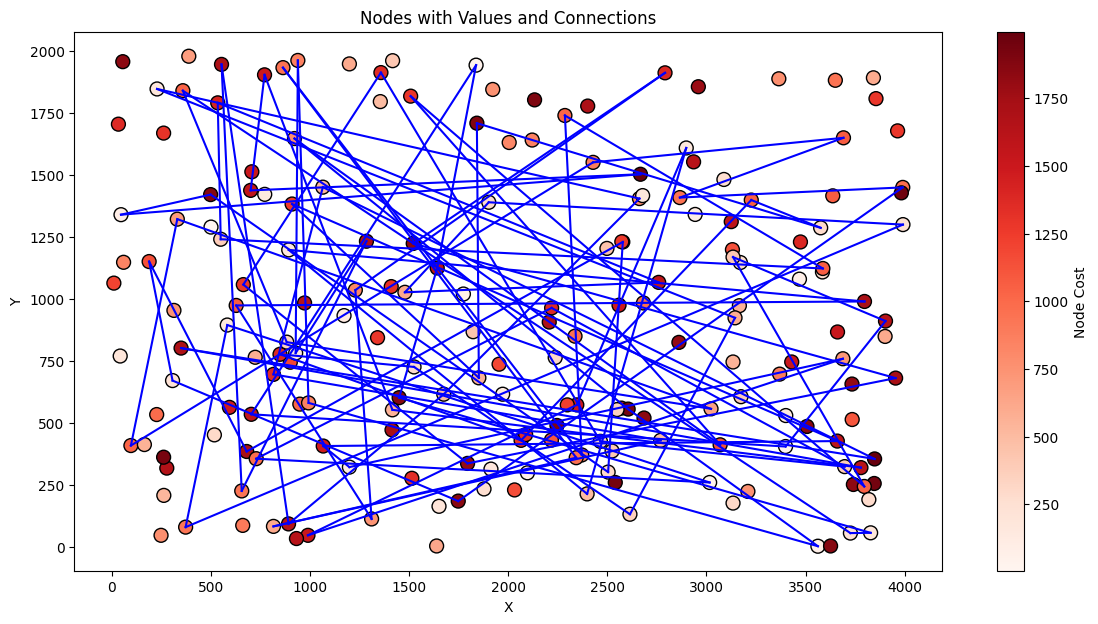

Acheived Total Score: 268909


In [8]:
def random_solution(distance_matrix, weights, start_node):
    '''
    Returns a random solution to the TSP problem based on the provided distance matrix.

    Parameters:
    distance_matrix: numpy.array containing distances between the nodes.
    weights: numpy.array containing the weights associated with each node.
    start_node: int, the index of the node from which the cycle starts.
    '''

    remaining_nodes = list(range(len(distance_matrix)))
    remaining_nodes.remove(start_node)
    np.random.shuffle(remaining_nodes)
    solution = [start_node] + remaining_nodes[:len(distance_matrix)//2 - 1]
    score = calculate_score(solution, distance_matrix, weights)
    return solution, score

sol, score = random_solution(distance_matrix, weights, np.random.randint(0, len(weights)))
sol = np.append(sol, sol[0])
plot_nodes_with_lines(df, sol)
print(f"Acheived Total Score: {score}")

## Nearest Neighbor - End of Path

In [9]:
def nearest_neighbor_end(distance_matrix, weights, start_node):
    '''
    Greedy solution to the TSP problem that selects the closest node to the previously selected.

    Parameters:
    distance_matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    start_node: int, the index of the node from which the cycle starts.
    '''
    d_matrix = np.copy(distance_matrix)
    d_matrix = d_matrix.astype(np.float64)
    np.fill_diagonal(d_matrix, np.inf)
    num_nodes = d_matrix.shape[0]
    solution = np.zeros(num_nodes//2, dtype=np.int64)

    solution[0] = start_node
    d_matrix[start_node] = np.inf
    
    next_node = start_node
    i = 1
    while i < num_nodes//2:
        next_node = np.argmin(d_matrix[:, next_node] + weights)
        d_matrix[next_node] = np.inf
        solution[i] = next_node
        i += 1

    score = calculate_score(solution, distance_matrix, weights)
    return solution, score

In [10]:
df['distance'] = np.sqrt(df['x']**2 + df['y']**2)
    
# Get the row with the minimum distance
start_node = df.iloc[df['distance'].idxmin()].name
start_node

10

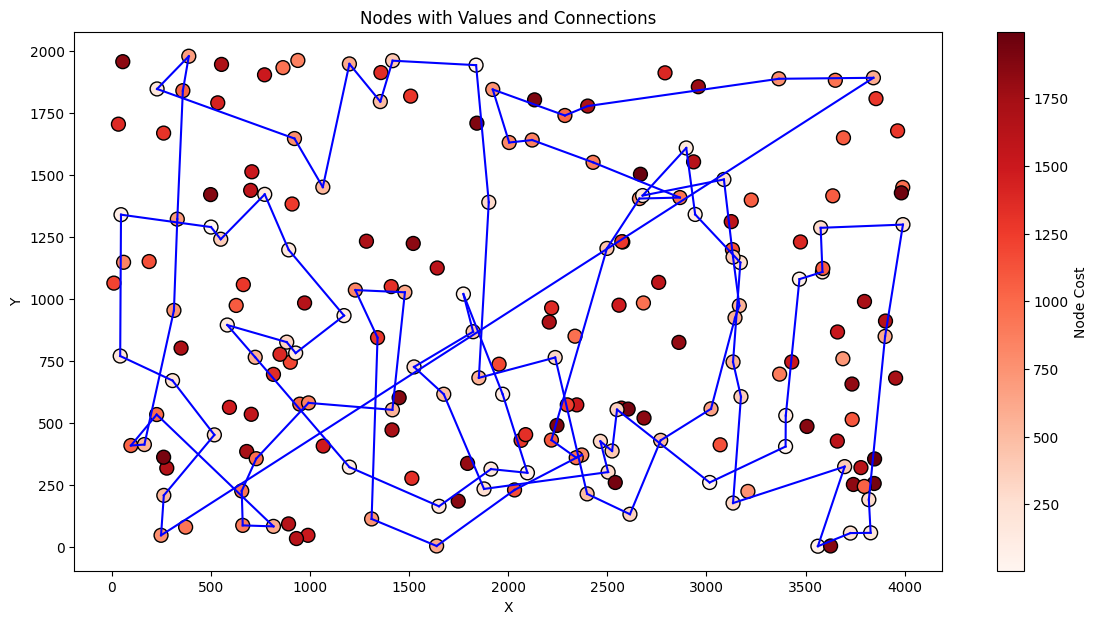

(x           249.000000
 y            47.000000
 val         774.000000
 distance    253.396922
 Name: 10, dtype: float64,
 86282)

In [11]:
sol, score = nearest_neighbor_end(distance_matrix, weights, start_node)
sol = np.append(sol, sol[0])
plot_nodes_with_lines(df, sol)
df.iloc[start_node], score

## Nearest Neighbor - Adding Node at All Positions

In [12]:
def nearest_neighbor_all(distance_matrix, weights, start_node):
    '''
    Greedy solution to the TSP problem that selects the closest node from all previously selected.

    Parameters:
    distance_matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    start_node: int, the index of the node from which the cycle starts.
    '''
    d_matrix = np.copy(distance_matrix)
    d_matrix = d_matrix.astype(np.float64)
    np.fill_diagonal(d_matrix, np.inf)
    num_nodes = d_matrix.shape[0]

    d_matrix[start_node] = np.inf
    
    solution = [start_node]

    i = 1
    while i < num_nodes//2:
        j = 0
        best_found = np.inf
        insert_node_idx = None
        insert_node_nearest = None    

        while j < i:
            tested_node = solution[j]

            nearest_node = np.argmin(d_matrix[:, tested_node] + weights)
            min_cost = d_matrix[:, tested_node][nearest_node] + weights[nearest_node]

            if min_cost < best_found:
                best_found = min_cost
                insert_node_idx = j+1
                insert_node_nearest = nearest_node            

            j += 1

        d_matrix[insert_node_nearest] = np.inf
        solution.insert(insert_node_idx, insert_node_nearest)

        i += 1

    score = calculate_score(solution, distance_matrix, weights)
    return solution, score

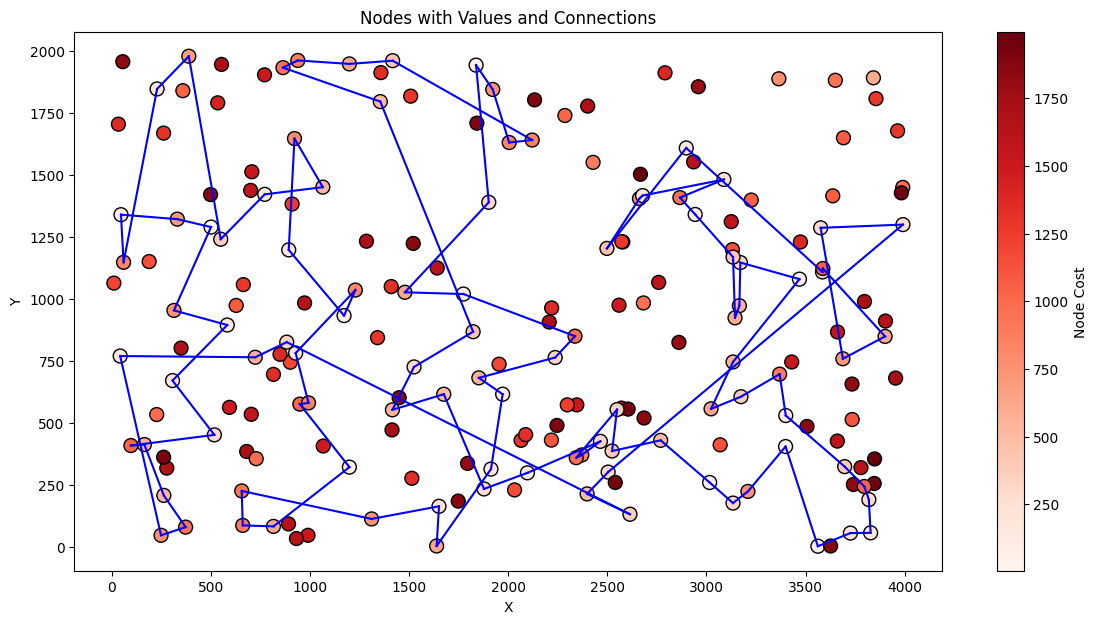

(x           249.000000
 y            47.000000
 val         774.000000
 distance    253.396922
 Name: 10, dtype: float64,
 80443)

In [13]:
sol, score = nearest_neighbor_all(distance_matrix, weights, start_node)
sol.append(sol[0])
plot_nodes_with_lines(df, sol)
df.iloc[start_node], score

## Greedy Cycle

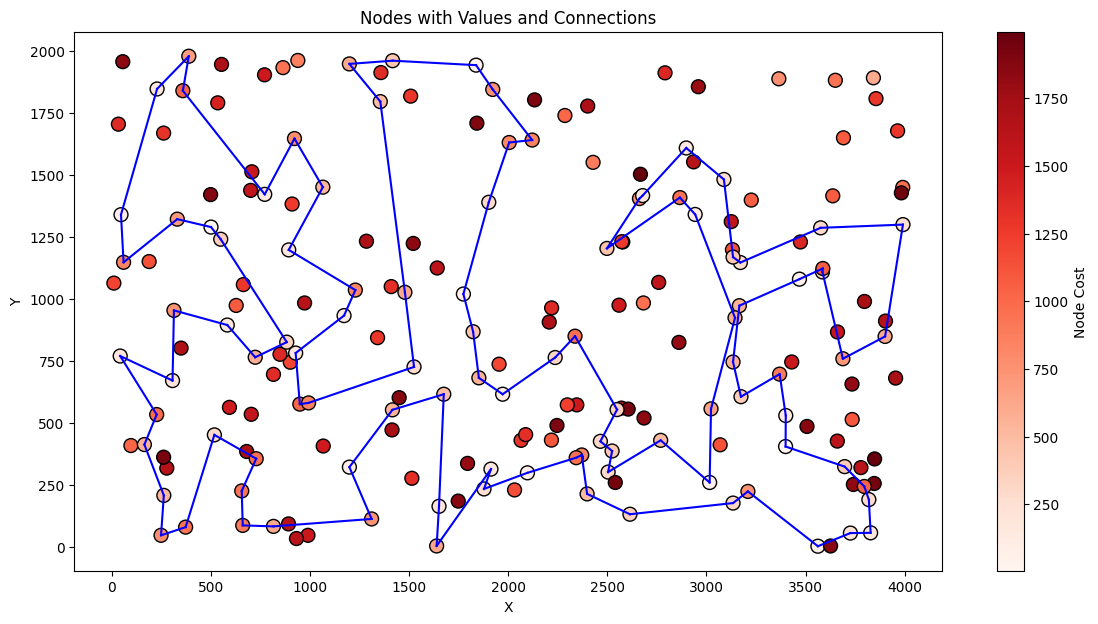

Acheived Total Score: 72712


In [14]:
def greedy_cycle(matrix, weights, starting_node):
    '''
    Implements a greedy cycle algorithm to solve the Traveling Salesman Problem (TSP).

    Parameters:
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    starting_node: int, the index of the node from which the cycle starts.
    '''
    distance_matrix = np.copy(matrix)
    distance_matrix = distance_matrix.astype(np.float64)
    np.fill_diagonal(distance_matrix, np.inf)
    solution = []
    num_nodes = distance_matrix.shape[0]
    score = 0

    distance_matrix[starting_node] = np.inf
    second_node = np.argmin(distance_matrix[:, starting_node] + weights)
    distance_matrix[second_node] = np.inf
    third_node = np.argmin(distance_matrix[:, starting_node] + distance_matrix[:, second_node] + weights)
    distance_matrix[third_node] = np.inf
    solution = [starting_node, second_node, third_node]
    score = calculate_score_three(solution, matrix, weights)

    num_iterations = round(num_nodes*0.5)-3
    for i in range(num_iterations):
        best_score = np.inf
        best_solution = None
        best_node = None
        for ii in range(len(solution)):
            new_score, new_solution, new_node = find_shortest_cycle(score, distance_matrix, matrix, weights, solution.copy(), ii)
            if new_score < best_score:
                best_score = new_score
                best_solution = new_solution
                best_node = new_node
        solution = best_solution.copy()
        score = best_score
        distance_matrix[best_node] = np.inf

    solution.append(solution[0])
    return solution, score

def calculate_score_three(solution, matrix, weights):
    '''
    Calculates the score (total distance) for a TSP cycle for the first three nodes. 

    Parameters:
    solution: list of three ints representing the node indices of the current cycle.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    '''
    score = 0
    node_1 = solution[0]
    node_2 = solution[1]
    node_3 = solution[2]
    score += matrix[node_1][node_2] + weights[node_1]
    score += matrix[node_2][node_3] + weights[node_2]
    score += matrix[node_3][node_1] + weights[node_3]
    return score

def find_shortest_cycle(score, distance_matrix, matrix, weights, solution, idx):
    '''
    Attempts to improve an existing TSP cycle by inserting a new node into the cycle 
    at the given position (idx).

    Parameters:
    score: float, the current total distance score.
    distance_matrix: numpy.array containing distances between nodes with some nodes set to infinity to avoid re-selection.
    matrix: numpy.array containing the original distances between nodes (no infinities).
    weights: numpy.array containing the weights for each node.
    solution: list of ints representing the current solution.
    idx: int, the index in the cycle where a new node might be inserted.
    '''
    node_1 = solution[idx-1]
    node_2 = solution[idx]
    score -= matrix[node_1][node_2]
    new_node = np.argmin(distance_matrix[:, node_1] + distance_matrix[:, node_2] + weights)
    solution.insert(idx, new_node)
    score += matrix[node_1][new_node] + matrix[new_node][node_2] + weights[new_node]
    return score, solution, new_node


solution, score = greedy_cycle(distance_matrix, weights, start_node)
plot_nodes_with_lines(df, solution)
print(f"Acheived Total Score: {score}")

## Experiments

In [15]:
def test_algorithm(algorithm, distance_matrix, weights, num_runs = 200):
    '''
    Tests chosen algorithm for each node run num_runs times.

    Parameters:
    algorithm: Function to test
    distance_matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    num_runs: integer, number of tests per node (default: 200)
    '''
    all_nodes = [i for i in range(len(weights))]
    results = {node: [] for node in all_nodes}
    solutions = {node: [] for node in all_nodes}
    for node in all_nodes:
        for i in range(num_runs):
            solution, score = algorithm(distance_matrix, weights, node)
            solutions[node].append(solution)
            results[node].append(score)
    return solutions, results

In [16]:
random_solutions, random_results = test_algorithm(random_solution, distance_matrix, weights)

In [17]:
nn_closest_solutions, nn_closest_results = test_algorithm(nearest_neighbor_end, distance_matrix, weights)

In [18]:
nn_all_solutions, nn_all_results = test_algorithm(nearest_neighbor_all, distance_matrix, weights)

In [19]:
cycle_solutions, cycle_results = test_algorithm(greedy_cycle, distance_matrix, weights)

## Results

In [20]:
def plot_nodes_with_lines_and_score(df, score, connections=None):
    """
    Plots nodes with optional lines connecting them, using a color scale to represent values.
    
    Parameters:
    df: DataFrame of nodes, each with 'x', 'y', and 'val'.
    connections: list of node indices in the DataFrame to connect in order.
    """
    plt.figure(figsize=(14, 7))
    norm = plt.Normalize(vmin=df.val.min(), vmax=df.val.max())
    colors = cm.Reds(norm(df.val))
    scatter = plt.scatter(df.x, df.y, c=df.val, cmap='Reds', s=100, edgecolors='black')

    if connections is not None:
        for start, end in zip(connections[:-1], connections[1:]):
            plt.plot([df.x[start], df.x[end]], [df.y[start], df.y[end]], color='blue')
        plt.plot([df.x[connections[-1]], df.x[connections[0]]], [df.y[connections[-1]], df.y[connections[0]]], color='blue')
    cbar = plt.colorbar(scatter)
    cbar.set_label('Node Cost')

    plt.xlabel('X')
    plt.ylabel('Y')
    title = f'Nodes with Color-Scaled Values, Score: {score}' if connections is None else f'Nodes with Color-Scaled Values, Score: {score}'
    plt.title(title)
    plt.grid(False)
    plt.show()

def plot_score_distribution(score_dict, label):
    all_scores = []
    for key in score_dict.keys():
        for item in score_dict[key]:
            all_scores.append(item)
    plt.hist(all_scores, bins=30, density=True, edgecolor='black', color="black", alpha=0.7)
    plt.title(f'Distribution of Scores Across All Nodes For {label}')
    plt.xlabel('Score Value')
    plt.ylabel('Relative Frequency')
    plt.show()

def plot_distribution_node(score_dict, node, label):
    all_scores = score_dict[node]
    plt.hist(all_scores, bins=30, density=True, edgecolor='black', color="black", alpha=0.7)
    plt.title(f'Distribution of Scores For {node} Node For {label}')
    plt.xlabel('Score Value')
    plt.ylabel('Relative Frequency')
    plt.show()

def plot_score_distributions(score_dict_1, score_dict_2, score_dict_3, score_dict_4, labels):
    all_scores_1 = []
    for key in score_dict_1.keys():
        for item in score_dict_1[key]:
            all_scores_1.append(item)

    all_scores_2 = []
    for key in score_dict_2.keys():
        for item in score_dict_2[key]:
            all_scores_2.append(item)

    all_scores_3 = []
    for key in score_dict_3.keys():
        for item in score_dict_3[key]:
            all_scores_3.append(item)

    all_scores_4 = []
    for key in score_dict_4.keys():
        for item in score_dict_4[key]:
            all_scores_4.append(item)
    
    plt.figure(figsize=(10, 6))
    
    sns.kdeplot(all_scores_1, label=labels[0], color='black', linewidth=2)
    sns.kdeplot(all_scores_2, label=labels[1], color='red', linewidth=2)
    sns.kdeplot(all_scores_3, label=labels[2], color='blue', linewidth=2)
    sns.kdeplot(all_scores_4, label=labels[3], color='green', linewidth=2)
    plt.xscale('log')
    
    # Add titles and labels
    plt.title('Continuous Distribution of Scores Across Different Nodes', fontsize=14)
    plt.xlabel('Score Value', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(loc='upper right')
    plt.show()


def plot_best_overall(df, solutions, results):
    all_scores = []
    for key in results.keys():
        for item in results[key]:
            all_scores.append(item)
    
    all_solutions = []
    for key in solutions.keys():
        for item in solutions[key]:
            all_solutions.append(item)
    
    all_scores = np.array(all_scores)
    best_overall = np.argmax(all_scores)
    best_solution = all_solutions[best_overall]
    plot_nodes_with_lines_and_score(df, all_scores[best_overall], best_solution)

def plot_best_for_node(df, solutions, results, node):
    all_solutions = solutions[node]
    all_results = np.array(results[node])
    best_solution = all_solutions[np.argmax(all_results)]
    plot_nodes_with_lines_and_score(df, all_results[np.argmax(all_results)], best_solution)

def plot_average_overall(df, solutions, results):
    all_scores = []
    for key in results.keys():
        for item in results[key]:
            all_scores.append(item)
    
    all_solutions = []
    for key in solutions.keys():
        for item in solutions[key]:
            all_solutions.append(item)

    all_scores = np.array(all_scores)
    median_index = np.argsort(all_scores)[len(all_scores) // 2]
    median_solution = all_solutions[median_index]
    plot_nodes_with_lines_and_score(df, all_scores[median_index], median_solution)
    
def plot_average_for_node(df, solutions, results, node):
    all_solutions = solutions[node]
    all_scores = results[node]
    all_scores = np.array(all_scores)
    median_index = np.argsort(all_scores)[len(all_scores) // 2]
    median_solution = all_solutions[median_index]
    plot_nodes_with_lines_and_score(df, all_scores[median_index], median_solution)

def plot_worst_overall(df, solutions, results):
    all_scores = []
    for key in results.keys():
        for item in results[key]:
            all_scores.append(item)
    
    all_solutions = []
    for key in solutions.keys():
        for item in solutions[key]:
            all_solutions.append(item)
    
    all_scores = np.array(all_scores)
    best_overall = np.argmin(all_scores)
    best_solution = all_solutions[best_overall]
    plot_nodes_with_lines_and_score(df, all_scores[best_overall], best_solution)

def plot_worst_for_node(df, solutions, results, node):
    all_solutions = solutions[node]
    all_results = np.array(results[node])
    best_solution = all_solutions[np.argmin(all_results)]
    plot_nodes_with_lines_and_score(df, all_results[np.argmin(all_results)], best_solution)

def calculate_stats_overall(results):
    all_scores = []
    for key in results.keys():
        for item in results[key]:
            all_scores.append(item)
    all_scores = np.array(all_scores)
    min_value = np.min(all_scores)
    max_value = np.max(all_scores)
    median_value = np.median(all_scores)
    mean_value = np.mean(all_scores)
    std_deviation = np.std(all_scores)
    return min_value, max_value, median_value, mean_value, std_deviation

def calculate_stats_node(results, node):
    all_scores = np.array(results[node])
    min_value = np.min(all_scores)
    max_value = np.max(all_scores)
    median_value = np.median(all_scores)
    mean_value = np.mean(all_scores)
    std_deviation = np.std(all_scores)
    return min_value, max_value, median_value, mean_value, std_deviation

### Random

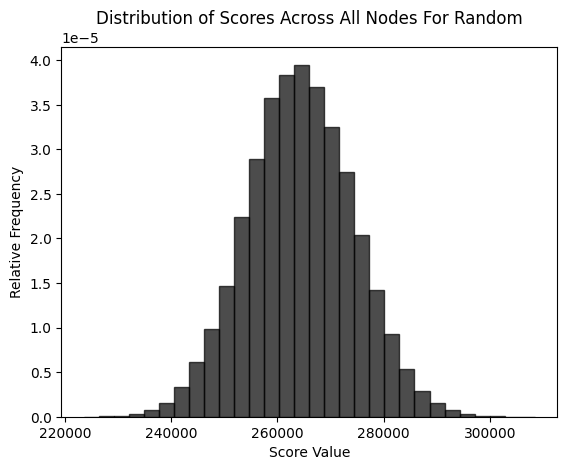

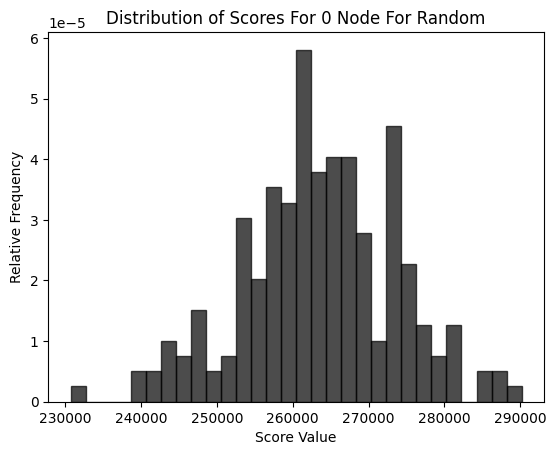

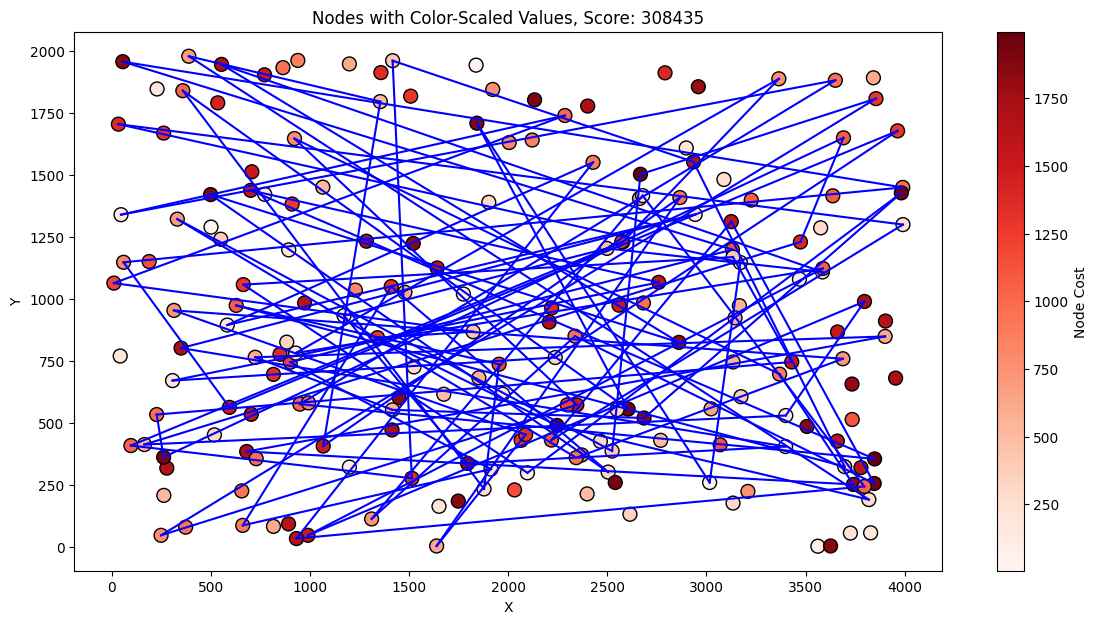

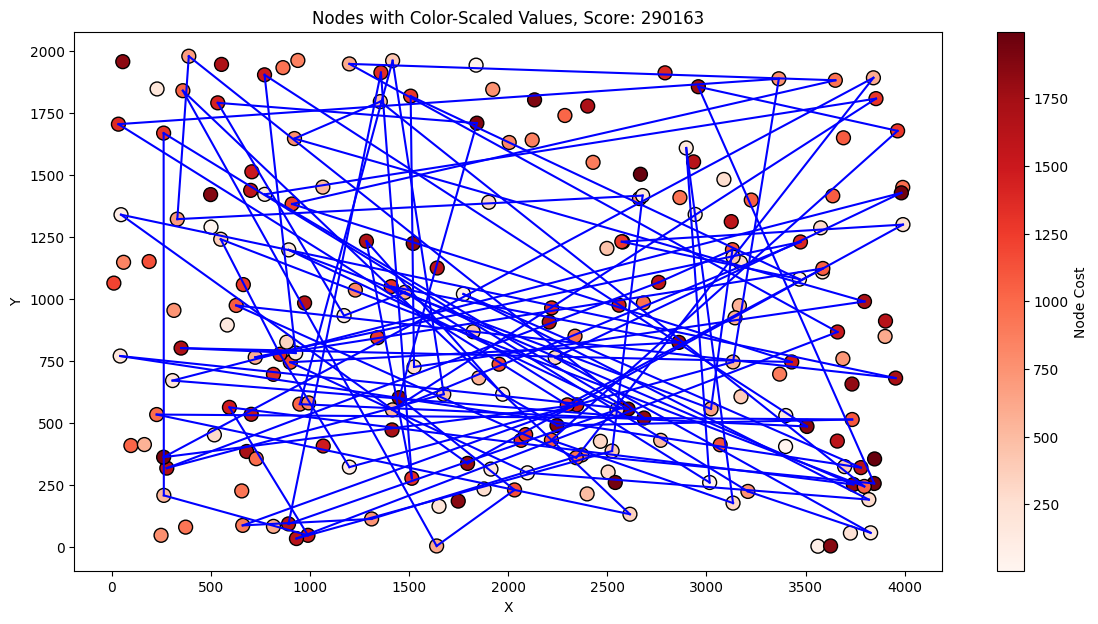

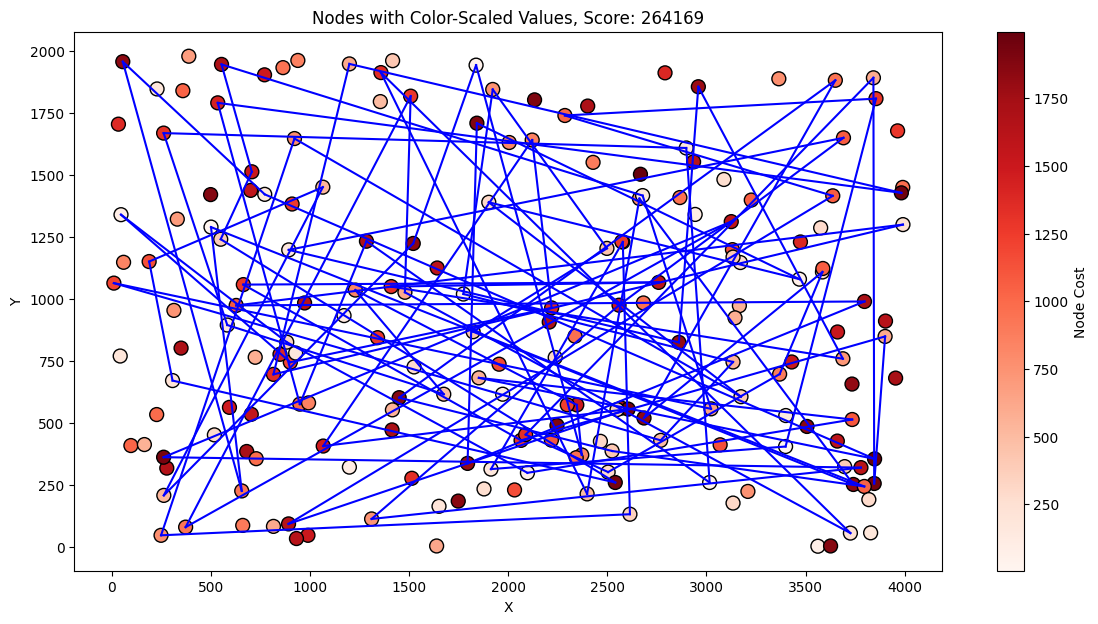

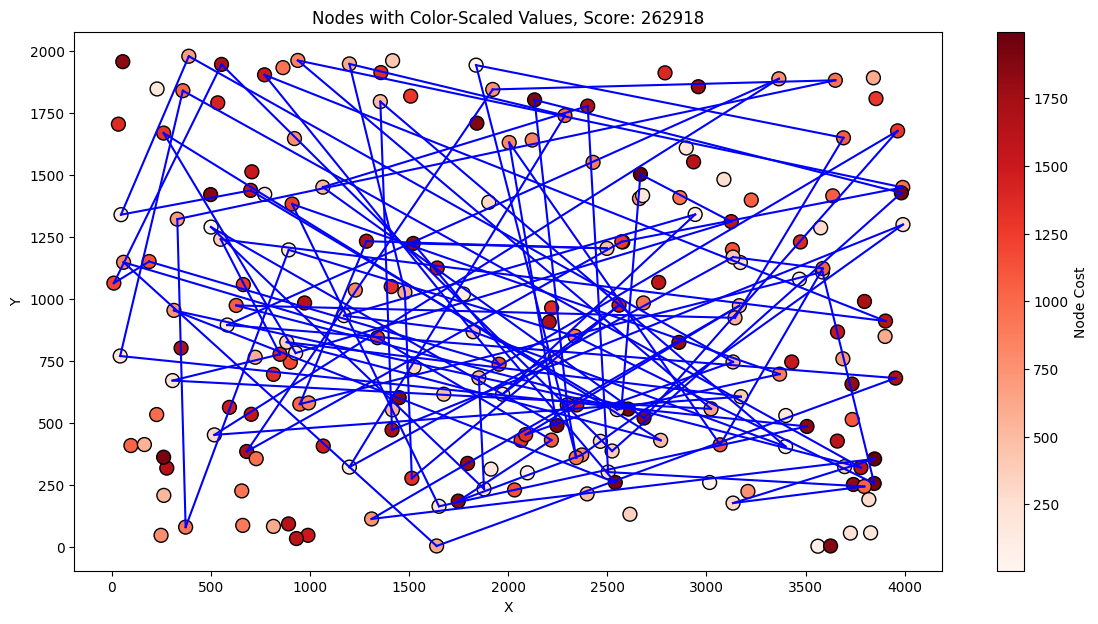

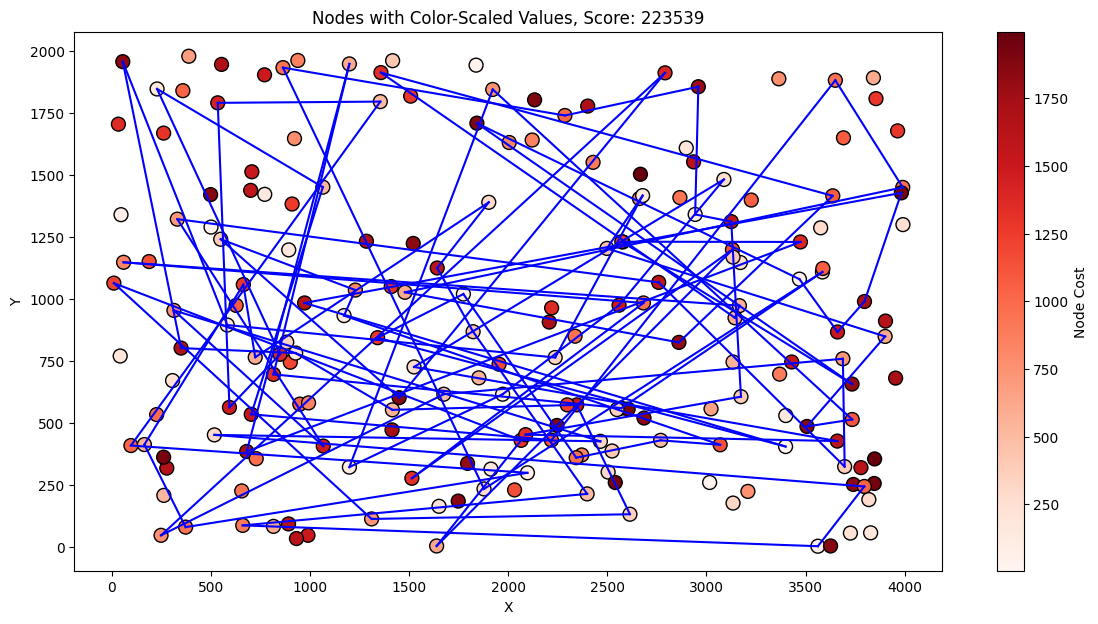

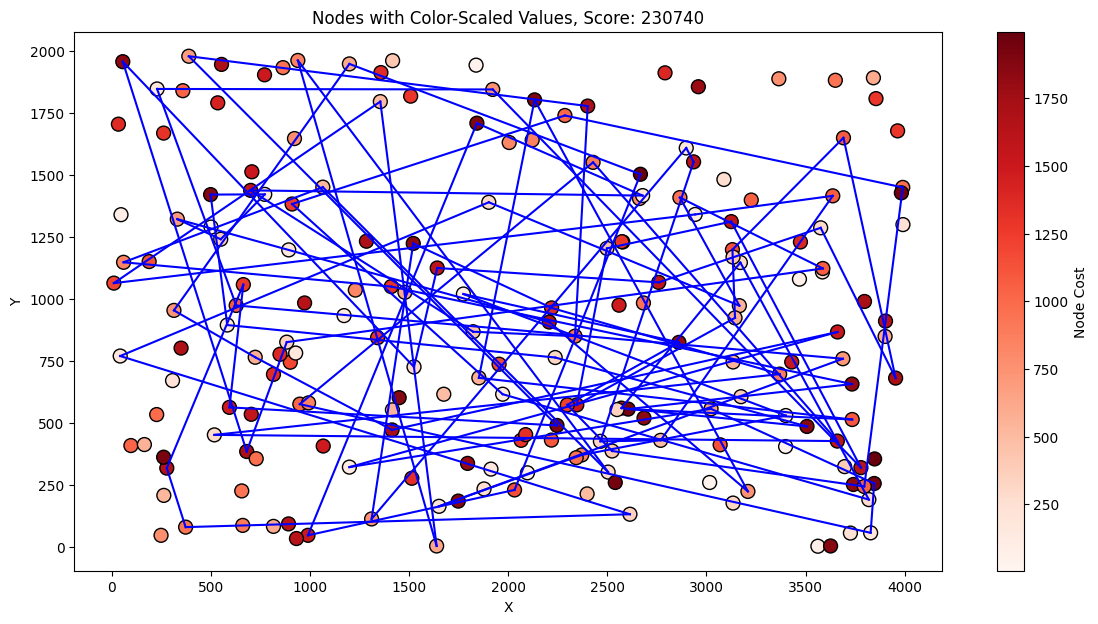

Overall Stats: 
 Minimum: 223539 Maximum: 308435 Median: 264169.0 Mean: 264301.22975 Standard Deviation: 10007.909240621386
Node stats for node 0 Stats: 
 Minimum: 230740 Maximum: 290163 Median: 262902.5 Mean: 263535.725 Standard Deviation: 10165.445576529097


In [21]:
plot_score_distribution(random_results, label="Random")
plot_distribution_node(random_results, node=0, label="Random")
plot_best_overall(df, random_solutions, random_results)
plot_best_for_node(df, random_solutions, random_results, node=0)
plot_average_overall(df, random_solutions, random_results)
plot_average_for_node(df, random_solutions, random_results, node=0)
plot_worst_overall(df, random_solutions, random_results)
plot_worst_for_node(df, random_solutions, random_results, node=0)
min_value, max_value, median_value, mean_value, std_deviation = calculate_stats_overall(random_results)
print(f"Overall Stats: \n Minimum: {min_value} Maximum: {max_value} Median: {median_value} Mean: {mean_value} Standard Deviation: {std_deviation}")
min_value, max_value, median_value, mean_value, std_deviation = calculate_stats_node(random_results, node=0)
print(f"Node stats for node {0} Stats: \n Minimum: {min_value} Maximum: {max_value} Median: {median_value} Mean: {mean_value} Standard Deviation: {std_deviation}")

### Nearest Neighbor - Added to The End

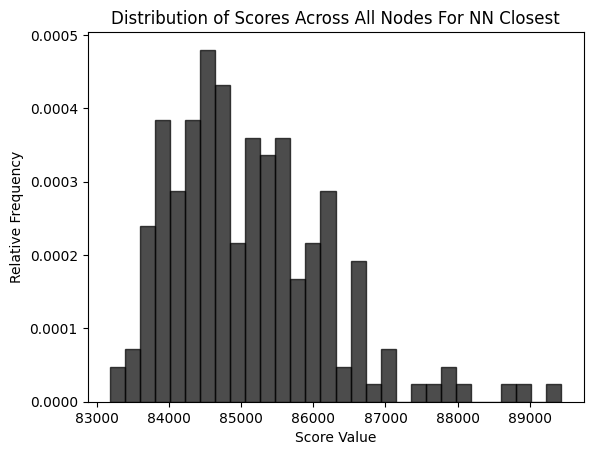

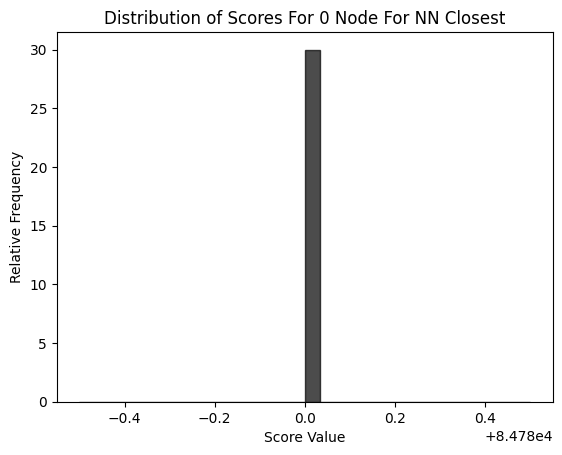

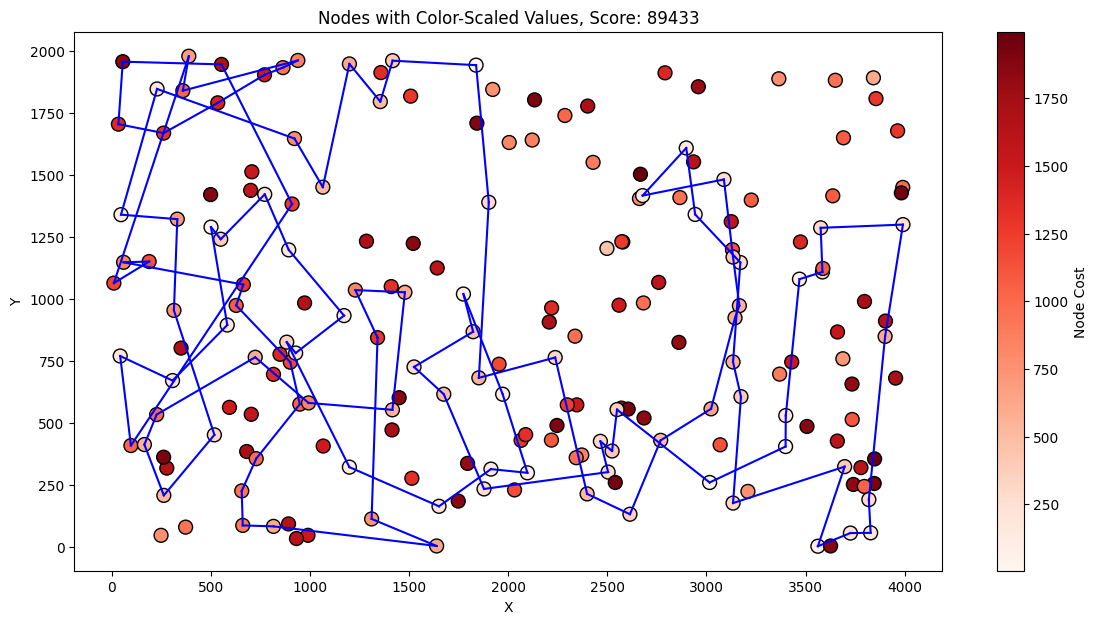

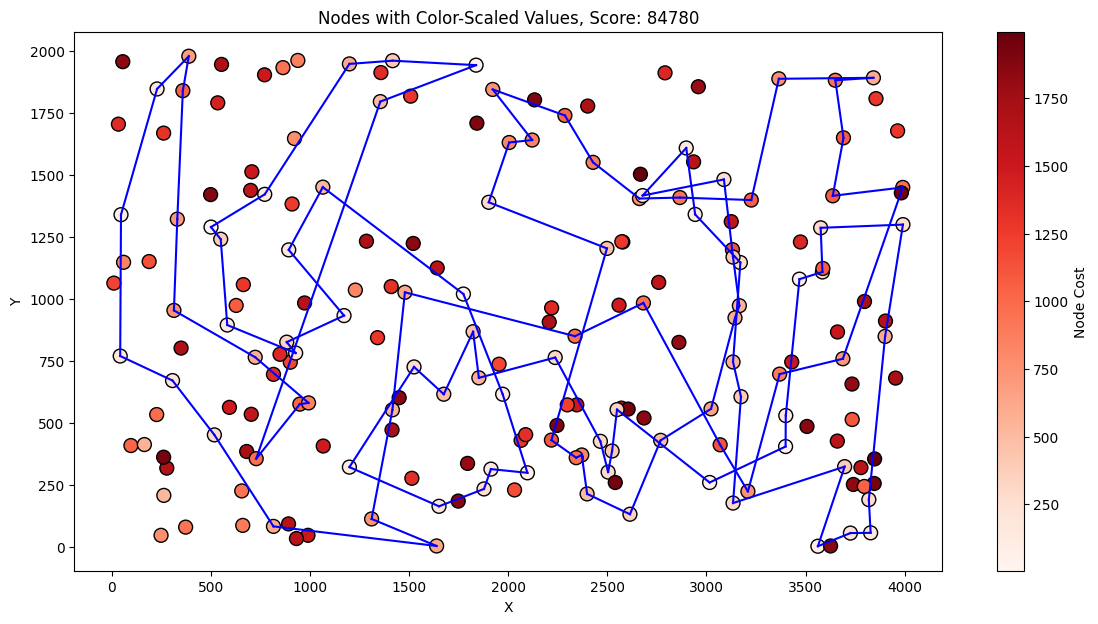

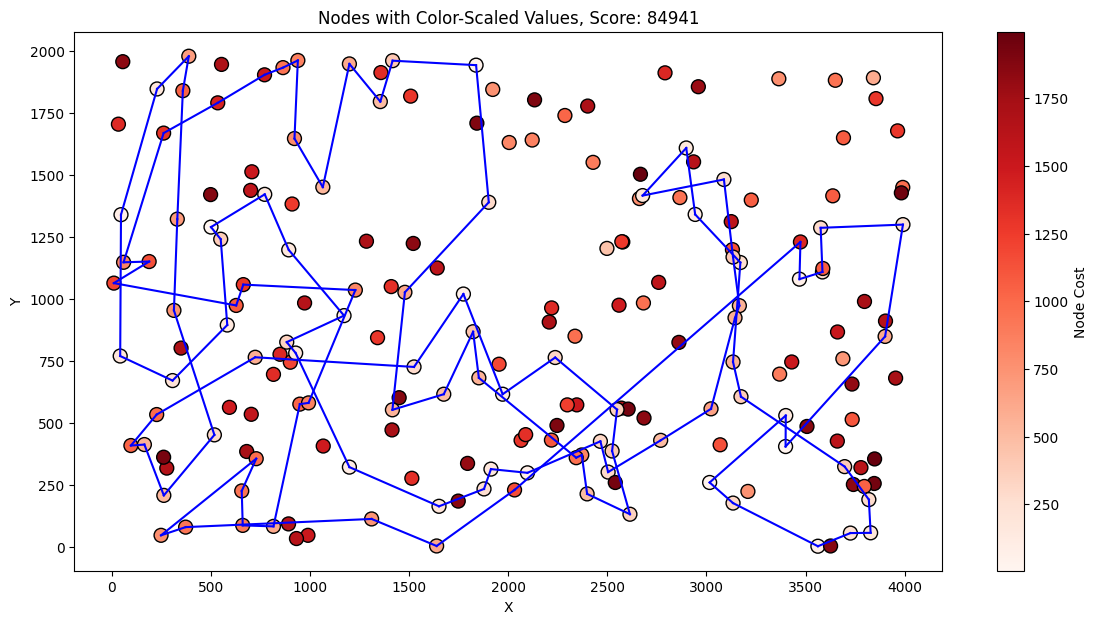

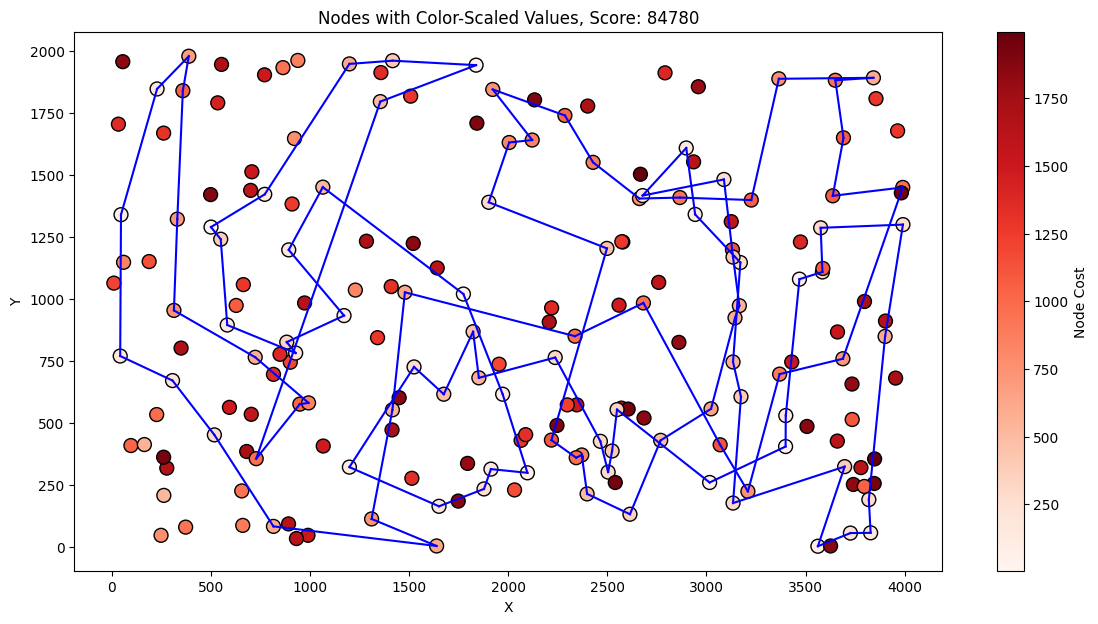

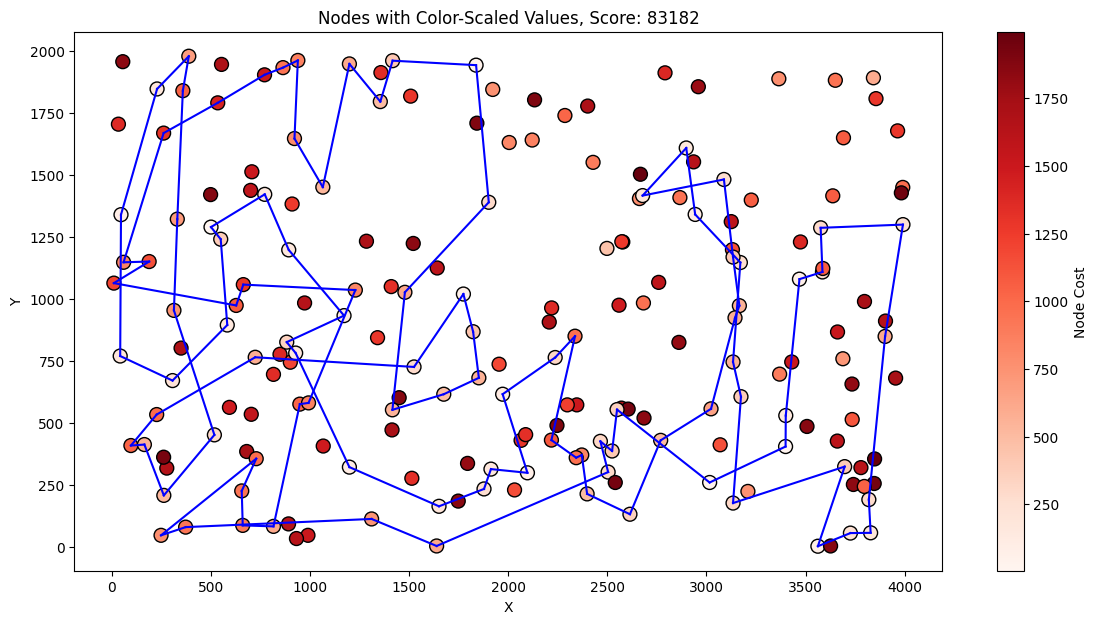

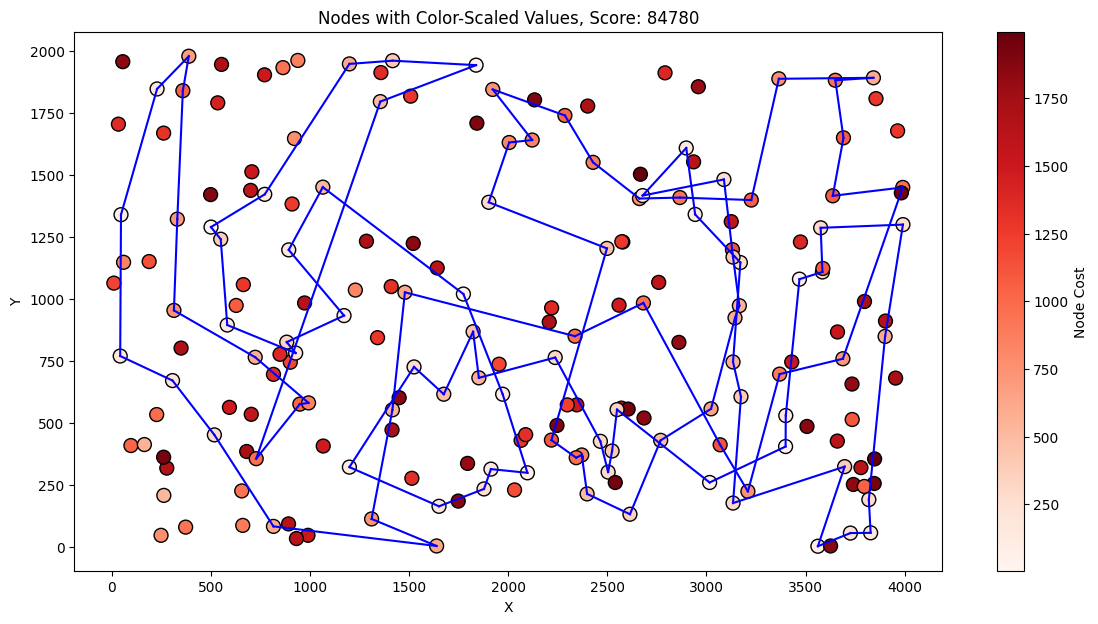

Overall Stats: 
 Minimum: 83182 Maximum: 89433 Median: 84923.5 Mean: 85108.51 Standard Deviation: 1084.7714413184005
Node stats for node 0 Stats: 
 Minimum: 84780 Maximum: 84780 Median: 84780.0 Mean: 84780.0 Standard Deviation: 0.0


In [22]:
plot_score_distribution(nn_closest_results, label="NN Closest")
plot_distribution_node(nn_closest_results, node=0, label="NN Closest")
plot_best_overall(df, nn_closest_solutions, nn_closest_results)
plot_best_for_node(df, nn_closest_solutions, nn_closest_results, node=0)
plot_average_overall(df, nn_closest_solutions, nn_closest_results)
plot_average_for_node(df, nn_closest_solutions, nn_closest_results, node=0)
plot_worst_overall(df, nn_closest_solutions, nn_closest_results)
plot_worst_for_node(df, nn_closest_solutions, nn_closest_results, node=0)
min_value, max_value, median_value, mean_value, std_deviation = calculate_stats_overall(nn_closest_results)
print(f"Overall Stats: \n Minimum: {min_value} Maximum: {max_value} Median: {median_value} Mean: {mean_value} Standard Deviation: {std_deviation}")
min_value, max_value, median_value, mean_value, std_deviation = calculate_stats_node(nn_closest_results, node=0)
print(f"Node stats for node {0} Stats: \n Minimum: {min_value} Maximum: {max_value} Median: {median_value} Mean: {mean_value} Standard Deviation: {std_deviation}")

### Nearest Neighbor - All Considered

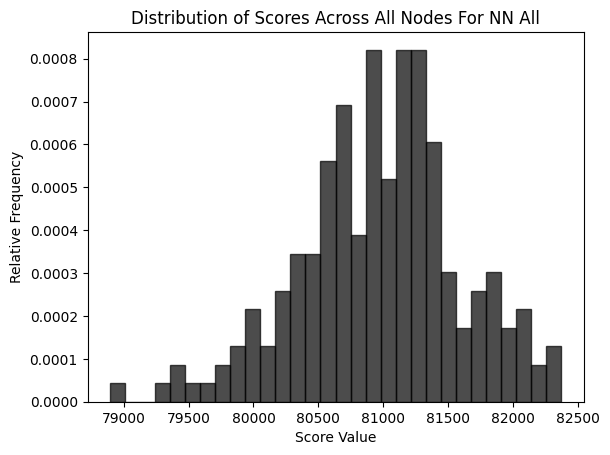

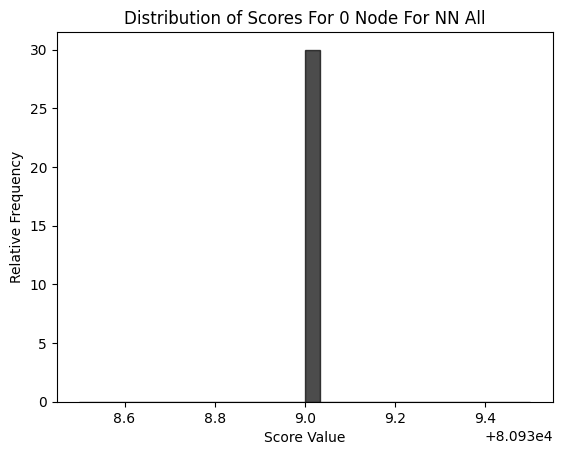

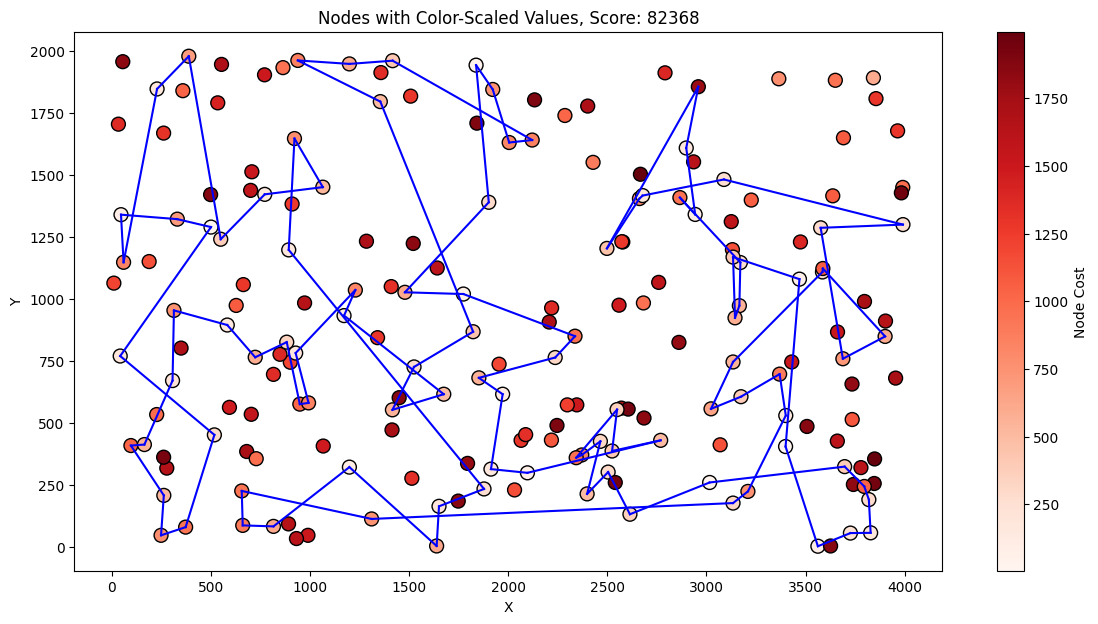

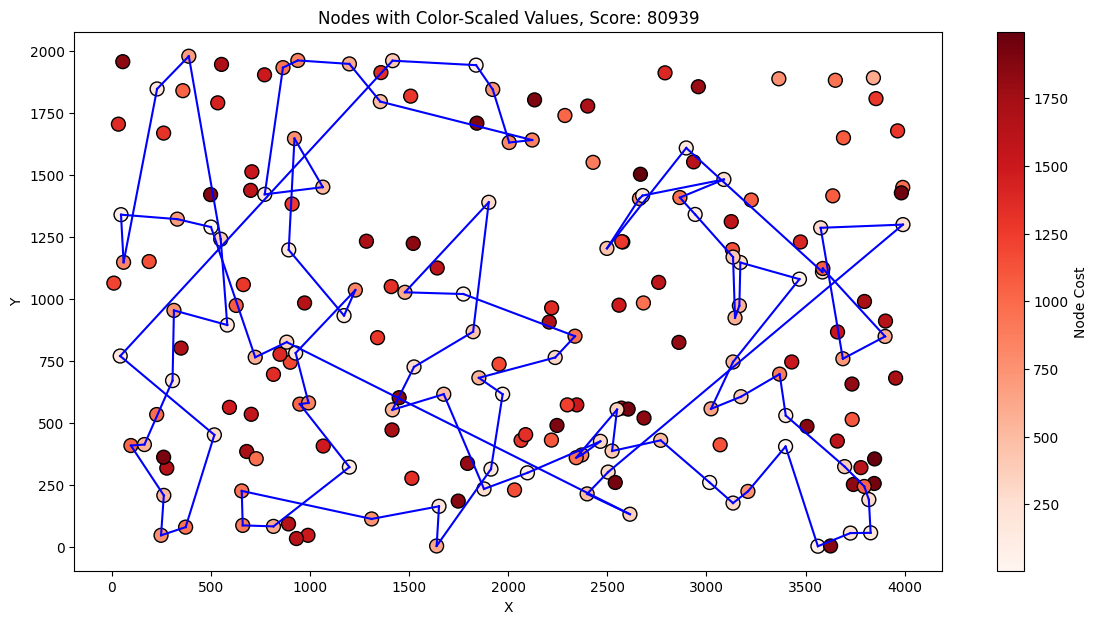

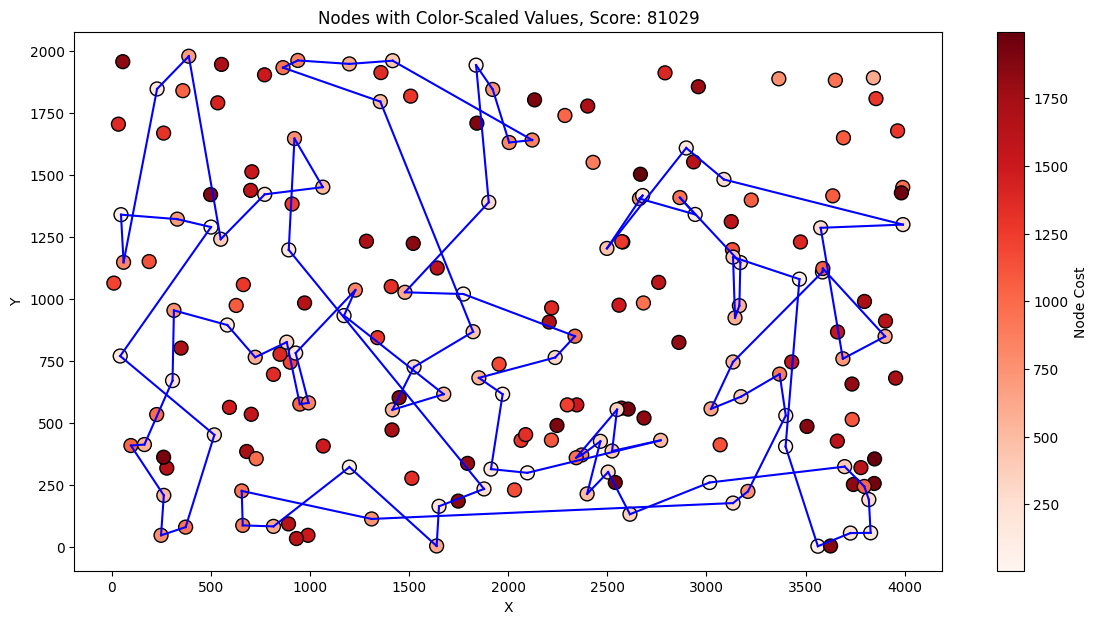

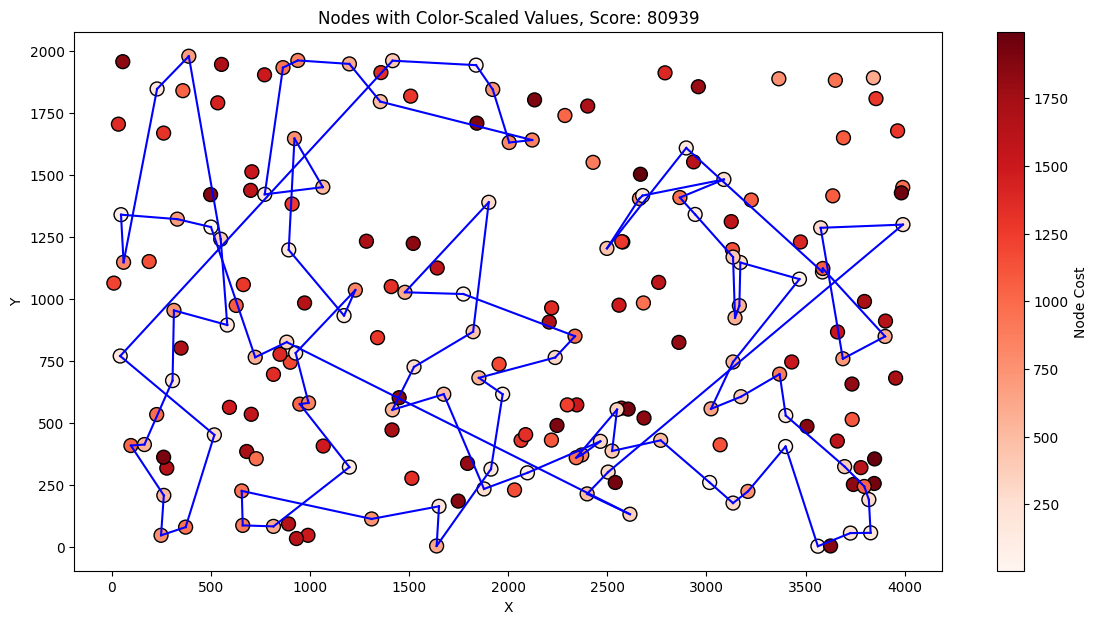

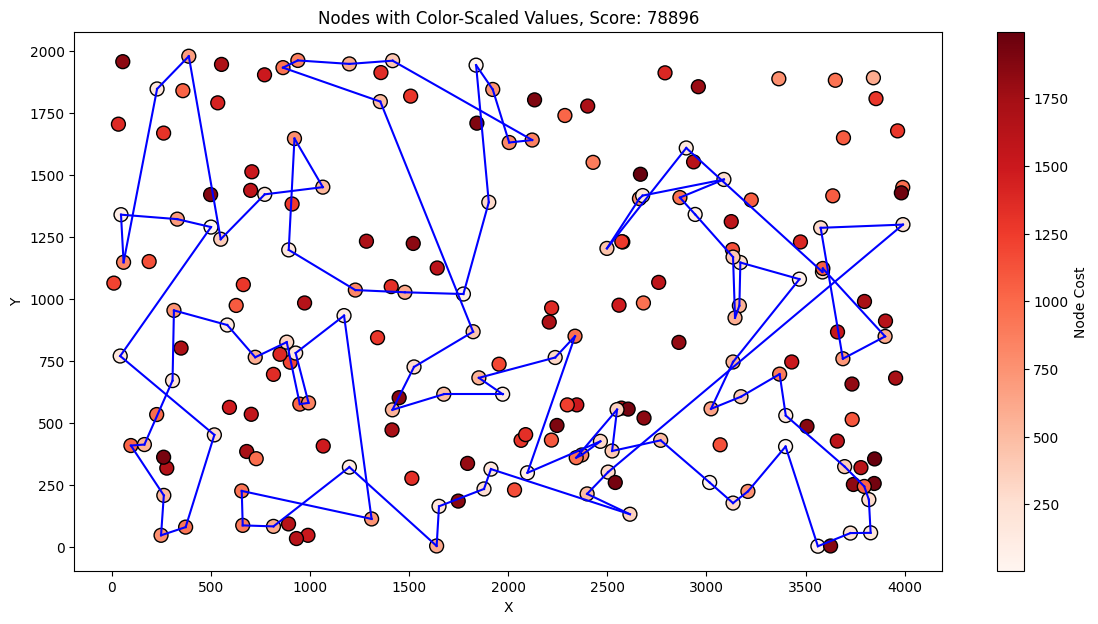

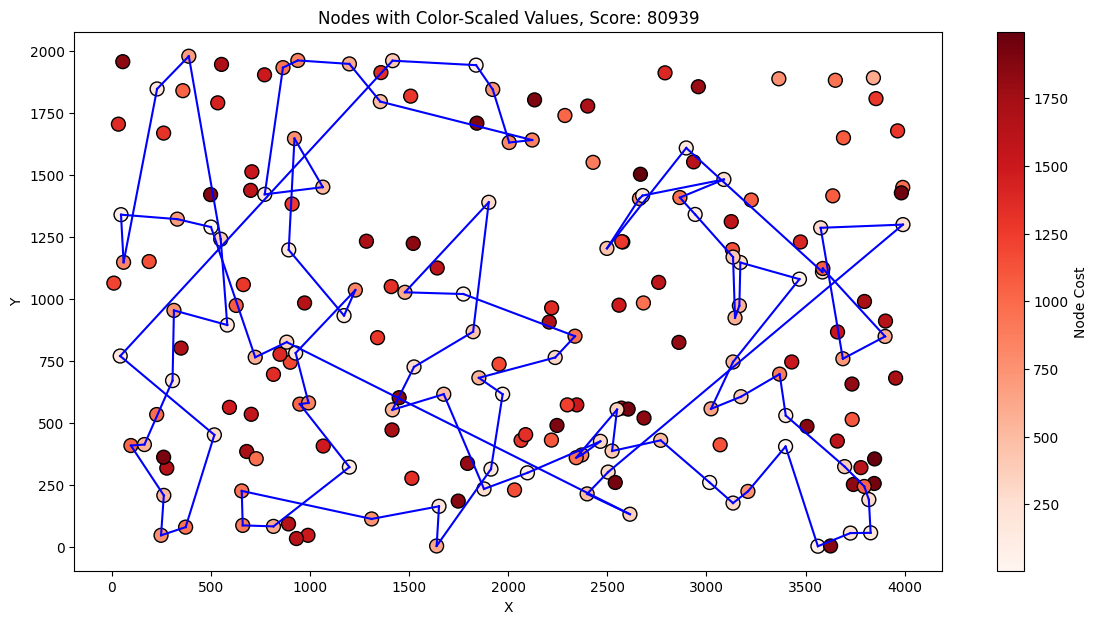

Overall Stats: 
 Minimum: 78896 Maximum: 82368 Median: 81016.5 Mean: 80974.365 Standard Deviation: 620.1210218779879
Node stats for node 0 Stats: 
 Minimum: 80939 Maximum: 80939 Median: 80939.0 Mean: 80939.0 Standard Deviation: 0.0


In [23]:
plot_score_distribution(nn_all_results, label="NN All")
plot_distribution_node(nn_all_results, node=0, label="NN All")
plot_best_overall(df, nn_all_solutions, nn_all_results)
plot_best_for_node(df, nn_all_solutions, nn_all_results, node=0)
plot_average_overall(df, nn_all_solutions, nn_all_results)
plot_average_for_node(df, nn_all_solutions, nn_all_results, node=0)
plot_worst_overall(df, nn_all_solutions, nn_all_results)
plot_worst_for_node(df, nn_all_solutions, nn_all_results, node=0)
min_value, max_value, median_value, mean_value, std_deviation = calculate_stats_overall(nn_all_results)
print(f"Overall Stats: \n Minimum: {min_value} Maximum: {max_value} Median: {median_value} Mean: {mean_value} Standard Deviation: {std_deviation}")
min_value, max_value, median_value, mean_value, std_deviation = calculate_stats_node(nn_all_results, node=0)
print(f"Node stats for node {0} Stats: \n Minimum: {min_value} Maximum: {max_value} Median: {median_value} Mean: {mean_value} Standard Deviation: {std_deviation}")

### Greedy Cycle

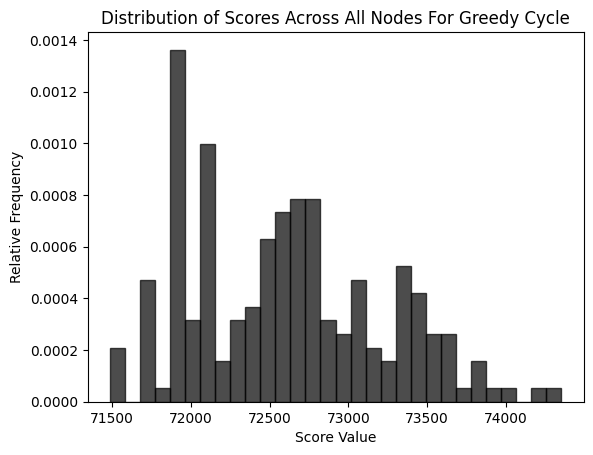

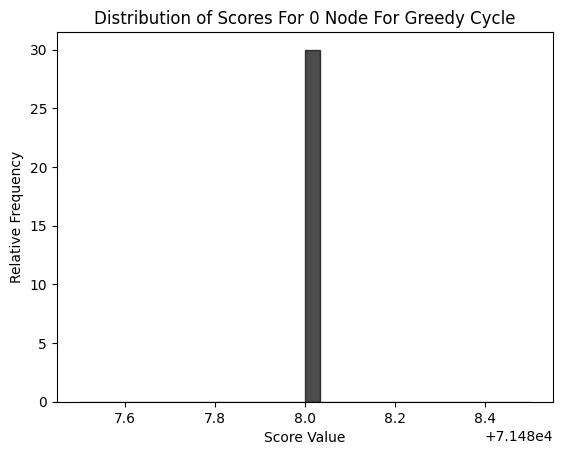

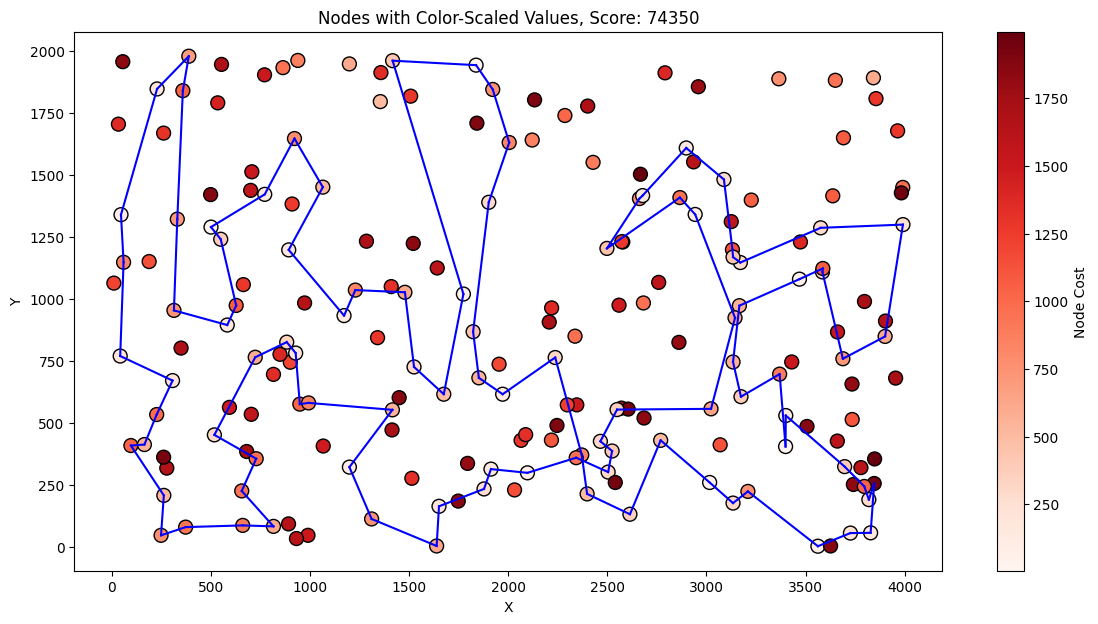

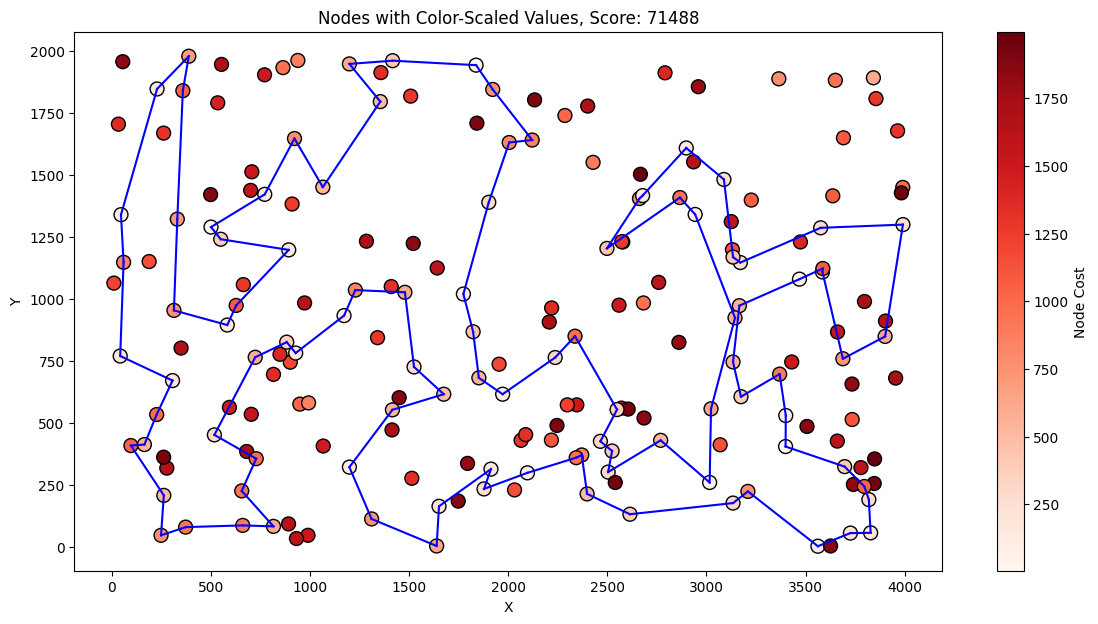

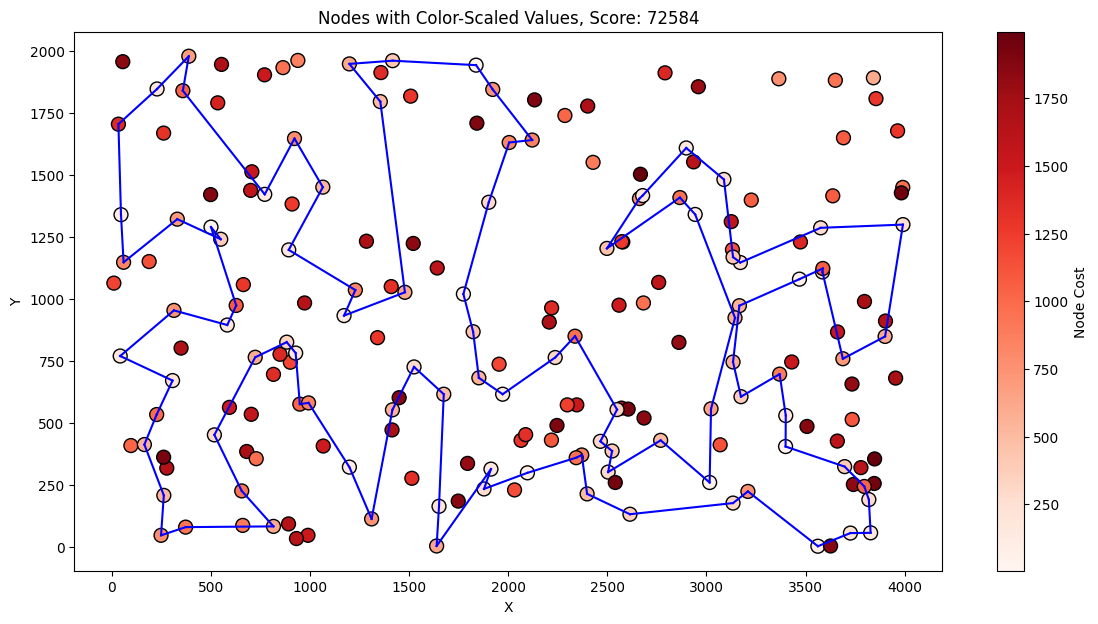

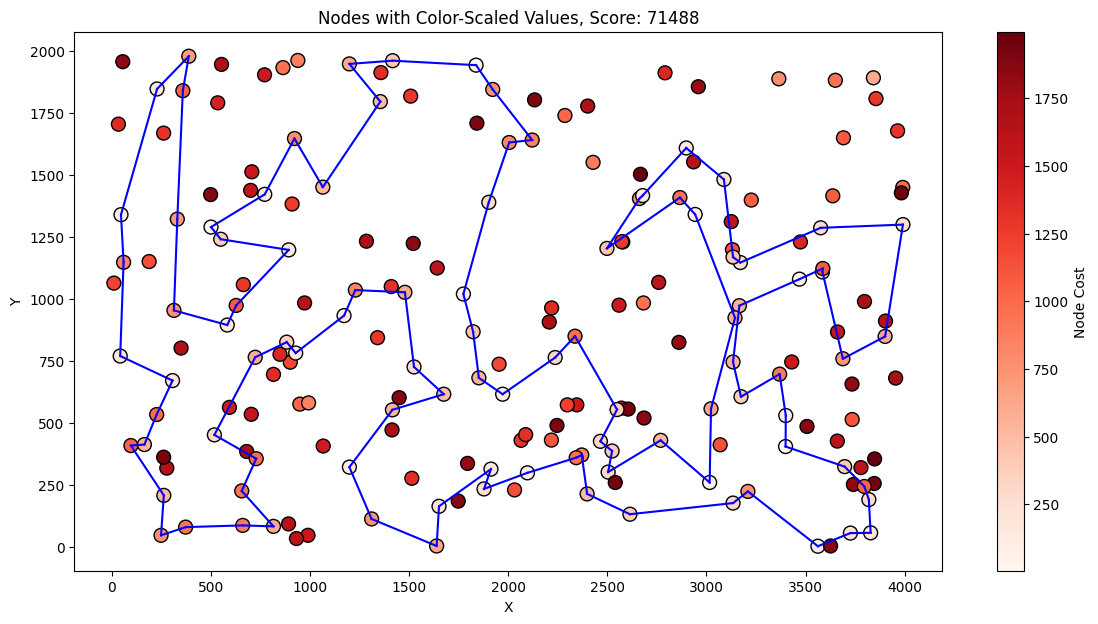

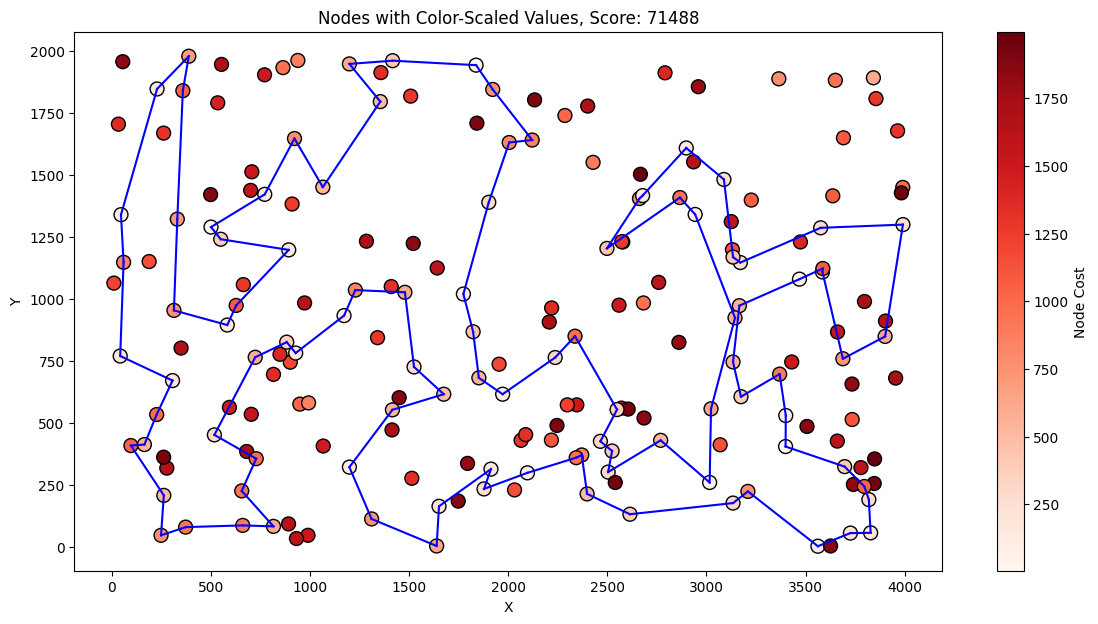

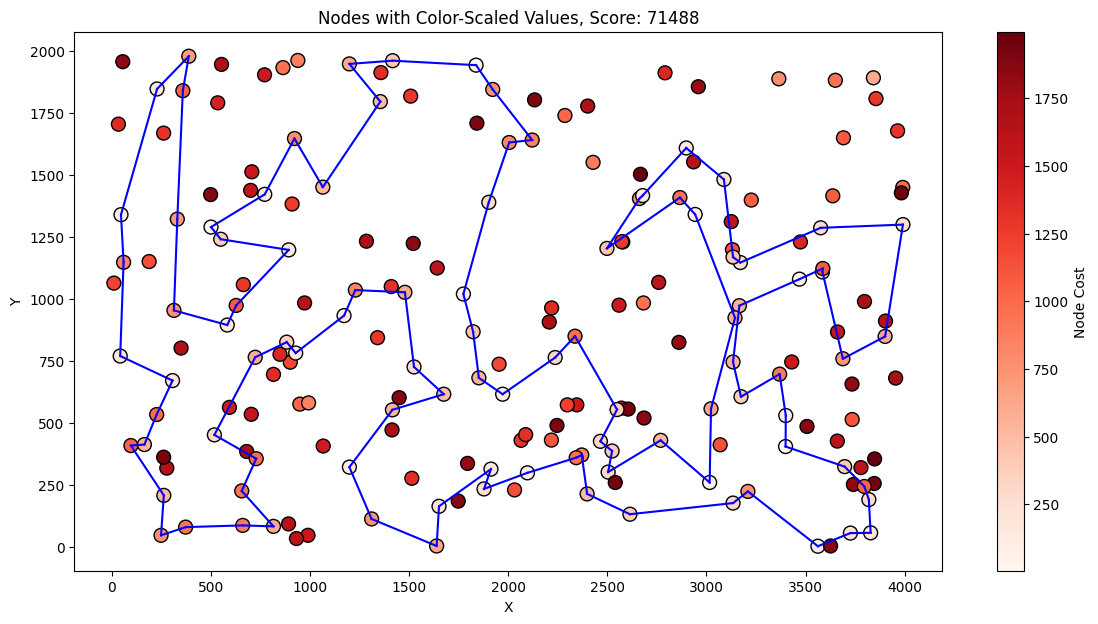

Overall Stats: 
 Minimum: 0 Maximum: 199 Median: 95.5 Mean: 96.95 Standard Deviation: 56.368363915365194
Node stats for node 0 Stats: 
 Minimum: 71488 Maximum: 71488 Median: 71488.0 Mean: 71488.0 Standard Deviation: 0.0


In [24]:
plot_score_distribution(cycle_results, label="Greedy Cycle")
plot_distribution_node(cycle_results, node=0, label="Greedy Cycle")
plot_best_overall(df, cycle_solutions, cycle_results)
plot_best_for_node(df, cycle_solutions, cycle_results, node=0)
plot_average_overall(df, cycle_solutions, cycle_results)
plot_average_for_node(df, cycle_solutions, cycle_results, node=0)
plot_worst_overall(df, cycle_solutions, cycle_results)
plot_worst_for_node(df, cycle_solutions, cycle_results, node=0)
min_value, max_value, median_value, mean_value, std_deviation = calculate_stats_overall(cycle_solutions)
print(f"Overall Stats: \n Minimum: {min_value} Maximum: {max_value} Median: {median_value} Mean: {mean_value} Standard Deviation: {std_deviation}")
min_value, max_value, median_value, mean_value, std_deviation = calculate_stats_node(cycle_results, node=0)
print(f"Node stats for node {0} Stats: \n Minimum: {min_value} Maximum: {max_value} Median: {median_value} Mean: {mean_value} Standard Deviation: {std_deviation}")

### All

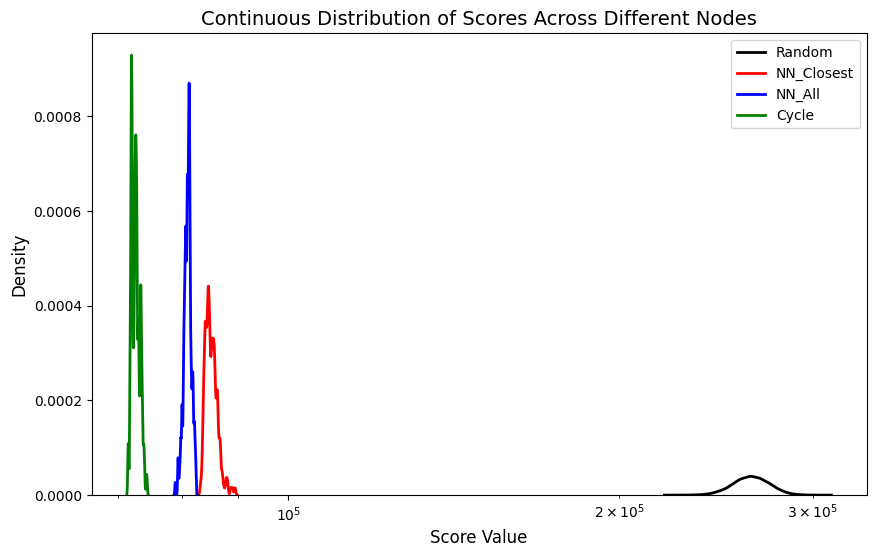

In [25]:
plot_score_distributions(random_results, nn_closest_results, nn_all_results, cycle_results, ["Random", "NN_Closest", "NN_All", "Cycle"])